# CANデータGPU処理ベンチマーク

CANバイナリデータのGPU処理とCPU処理の比較、およびParquet出力の検証を行います。

## 1. 環境設定とインポート

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import sys

# Add parent directory to path for imports
sys.path.append('..')

# Import decoders
from gpu_can_decoder import GPUCANDecoder
from gpu_can_decoder_optimized import OptimizedGPUCANDecoder
from cpu_can_decoder import CPUCANDecoder

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [8]:
def generate_synthetic_can_data(n_messages):
    """合成CANデータの生成（OpenPilot DBCファイルに準拠）"""
    # リアルなCANデータ分布を模倣
    address_distribution = {
        170: 0.037,  # 4輪速度
        37: 0.037,   # ステアリング
        36: 0.037,
        740: 0.044,
        608: 0.022,
        180: 0.018,
    }
    
    # アドレスを生成
    addresses = []
    for addr, prob in address_distribution.items():
        count = int(n_messages * prob)
        addresses.extend([addr] * count)
    
    # 残りはランダムなアドレス
    remaining = n_messages - len(addresses)
    other_addresses = np.random.choice([452, 466, 467, 705, 321, 562], remaining)
    addresses.extend(other_addresses)
    
    # シャッフル
    np.random.shuffle(addresses)
    addresses = np.array(addresses[:n_messages], dtype=np.int64)
    
    # タイムスタンプ（実データと同じ範囲）
    timestamps = np.linspace(46408.0, 46468.0, n_messages)
    
    # データバイト
    data_bytes = np.zeros((n_messages, 8), dtype=np.uint8)
    
    for i in range(n_messages):
        if addresses[i] == 170:  # 4輪速度
            # OpenPilot DBC: (0.01,-67.67) "kph" for Toyota RAV4
            for j in range(4):
                speed_kmh = np.random.uniform(55, 65)  # 55-65 km/h
                raw_value = int((speed_kmh + 67.67) / 0.01)
                data_bytes[i, j*2] = (raw_value >> 8) & 0xFF
                data_bytes[i, j*2 + 1] = raw_value & 0xFF
        elif addresses[i] == 37:  # ステアリング
            # 固定値パターン（実データと同じ）
            data_bytes[i] = [0x00, 0x00, 0x10, 0x00, 0xC0, 0x00, 0x00, 0xFD]
        else:
            # その他はランダム
            data_bytes[i] = np.random.randint(0, 256, 8, dtype=np.uint8)
    
    return timestamps, addresses, data_bytes

In [9]:
# テスト用データの生成 - 10,000,000メッセージまで拡張
test_sizes = [
    10_000,        # 10K
    50_000,        # 50K
    100_000,       # 100K
    500_000,       # 500K
    1_000_000,     # 1M
    5_000_000,     # 5M
    10_000_000,    # 10M
]
print("テストデータサイズ:", test_sizes)

テストデータサイズ: [10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


## 1.1 生CANデータの列指向配列レイアウト

In [10]:
# 生CANデータの構造を確認
print("=== 生CANデータの列指向配列レイアウト ===\n")

# サンプルデータを生成して構造を表示
n_sample = 5
sample_timestamps, sample_addresses, sample_data_bytes = generate_synthetic_can_data(n_sample)

print("生CANデータは3つの列指向配列で構成されています：\n")

print("1. タイムスタンプ配列 (timestamps):")
print(f"   - 型: {sample_timestamps.dtype}")
print(f"   - 形状: {sample_timestamps.shape}")
print(f"   - 例: {sample_timestamps}")

print("\n2. アドレス配列 (addresses):")
print(f"   - 型: {sample_addresses.dtype}")
print(f"   - 形状: {sample_addresses.shape}")
print(f"   - 例: {sample_addresses}")

print("\n3. データバイト配列 (data_bytes):")
print(f"   - 型: {sample_data_bytes.dtype}")
print(f"   - 形状: {sample_data_bytes.shape}")
print(f"   - 例:")
for i in range(n_sample):
    print(f"     メッセージ{i}: {sample_data_bytes[i]}")

print("\n=== データレイアウトの特徴 ===")
print("- 列指向: 各属性（timestamp, address, data）が個別の配列として格納")
print("- 効率的: GPUでの並列処理に適した連続メモリレイアウト")
print("- Apache Arrow互換: 列指向フォーマットへの変換が容易")

=== 生CANデータの列指向配列レイアウト ===

生CANデータは3つの列指向配列で構成されています：

1. タイムスタンプ配列 (timestamps):
   - 型: float64
   - 形状: (5,)
   - 例: [46408. 46423. 46438. 46453. 46468.]

2. アドレス配列 (addresses):
   - 型: int64
   - 形状: (5,)
   - 例: [467 321 467 466 562]

3. データバイト配列 (data_bytes):
   - 型: uint8
   - 形状: (5, 8)
   - 例:
     メッセージ0: [152 140  98  84 116 144 139 172]
     メッセージ1: [224   7 107  89  92 131  77  46]
     メッセージ2: [  7  41  54  76 142 108 181   8]
     メッセージ3: [ 64  67 251  57 126 235 221  57]
     メッセージ4: [ 22 132 168 177 142  89   4 137]

=== データレイアウトの特徴 ===
- 列指向: 各属性（timestamp, address, data）が個別の配列として格納
- 効率的: GPUでの並列処理に適した連続メモリレイアウト
- Apache Arrow互換: 列指向フォーマットへの変換が容易


/tmp/ipykernel_4119469/1192433793.py:47: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4119469/1192433793.py:47: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4119469/1192433793.py:47: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4119469/1192433793.py:47: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4119469/1192433793.py:47: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4119469/1192433793.py:47: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4119469/1192433793.py:47: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGR

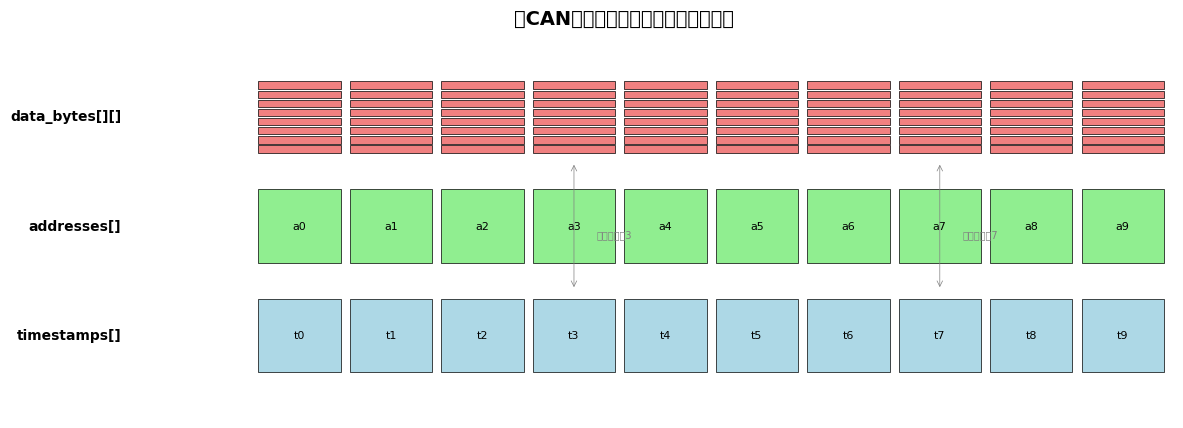


=== メモリ使用量の例 ===
    10,000 メッセージ:      0.2 MB
            - timestamps:    0.1 MB
            - addresses:     0.1 MB
            - data_bytes:    0.1 MB
   100,000 メッセージ:      2.3 MB
            - timestamps:    0.8 MB
            - addresses:     0.8 MB
            - data_bytes:    0.8 MB
 1,000,000 メッセージ:     22.9 MB
            - timestamps:    7.6 MB
            - addresses:     7.6 MB
            - data_bytes:    7.6 MB
10,000,000 メッセージ:    228.9 MB
            - timestamps:   76.3 MB
            - addresses:    76.3 MB
            - data_bytes:   76.3 MB


In [11]:
# メモリレイアウトの可視化
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 各配列のメモリ表現
n_messages = 10
bar_height = 0.8

# タイムスタンプ配列
for i in range(n_messages):
    rect = mpatches.Rectangle((i, 0), 0.9, bar_height, 
                            facecolor='lightblue', edgecolor='black', linewidth=0.5)
    ax.add_patch(rect)
    ax.text(i + 0.45, 0.4, f't{i}', ha='center', va='center', fontsize=8)

# アドレス配列
for i in range(n_messages):
    rect = mpatches.Rectangle((i, 1.2), 0.9, bar_height, 
                            facecolor='lightgreen', edgecolor='black', linewidth=0.5)
    ax.add_patch(rect)
    ax.text(i + 0.45, 1.6, f'a{i}', ha='center', va='center', fontsize=8)

# データバイト配列（2次元）
for i in range(n_messages):
    for j in range(8):
        rect = mpatches.Rectangle((i, 2.4 + j * 0.1), 0.9, 0.08, 
                                facecolor='lightcoral', edgecolor='black', linewidth=0.5)
        ax.add_patch(rect)

ax.text(-1.5, 0.4, 'timestamps[]', ha='right', va='center', fontweight='bold')
ax.text(-1.5, 1.6, 'addresses[]', ha='right', va='center', fontweight='bold')
ax.text(-1.5, 2.8, 'data_bytes[][]', ha='right', va='center', fontweight='bold')

ax.set_xlim(-2, n_messages)
ax.set_ylim(-0.5, 3.5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('生CANデータの列指向配列レイアウト', fontsize=14, fontweight='bold', pad=20)

# 矢印で各メッセージの関係を示す
for i in [3, 7]:  # 例として2つのメッセージ
    ax.annotate('', xy=(i + 0.45, 2.3), xytext=(i + 0.45, 0.9),
                arrowprops=dict(arrowstyle='<->', color='gray', lw=0.5))
    ax.text(i + 0.7, 1.5, f'メッセージ{i}', ha='left', va='center', fontsize=7, color='gray')

plt.tight_layout()
plt.show()

# 実際のデータサイズ計算
print("\n=== メモリ使用量の例 ===")
for n in [10_000, 100_000, 1_000_000, 10_000_000]:
    timestamp_size = n * 8  # float64
    address_size = n * 8    # int64
    data_size = n * 8 * 1   # uint8 * 8
    total_size = timestamp_size + address_size + data_size
    print(f"{n:>10,} メッセージ: {total_size / (1024**2):>8.1f} MB")
    print(f"            - timestamps: {timestamp_size / (1024**2):>6.1f} MB")
    print(f"            - addresses:  {address_size / (1024**2):>6.1f} MB")
    print(f"            - data_bytes: {data_size / (1024**2):>6.1f} MB")

## 2. GPU/CPU処理の実行と速度比較

In [12]:
# デコーダーの初期化
gpu_decoder = GPUCANDecoder(batch_size=500_000)
optimized_gpu_decoder = OptimizedGPUCANDecoder(batch_size=500_000, chunk_size=1)
cpu_decoder = CPUCANDecoder(batch_size=100_000)

# ベンチマーク結果格納
benchmark_results = []

for n_messages in test_sizes:
    print(f"\n--- {n_messages:,} メッセージの処理 ---")
    
    # データ生成
    timestamps, addresses, data_bytes = generate_synthetic_can_data(n_messages)
    data_size_mb = (timestamps.nbytes + addresses.nbytes + data_bytes.nbytes) / (1024**2)
    print(f"データサイズ: {data_size_mb:.1f} MB")
    
    # GPU処理（従来）
    gpu_start = time.time()
    gpu_results = gpu_decoder.decode_batch(timestamps, addresses, data_bytes)
    import cupy as cp
    cp.cuda.Stream.null.synchronize()  # GPU同期
    gpu_time = time.time() - gpu_start
    
    # GPU処理（最適化）
    opt_gpu_start = time.time()
    opt_gpu_chunk_results = optimized_gpu_decoder.decode_batch(timestamps, addresses, data_bytes)
    opt_gpu_time = time.time() - opt_gpu_start
    
    # CPU処理（大きいデータは時間がかかるため制限）
    if n_messages <= 100_000:
        cpu_start = time.time()
        cpu_results = cpu_decoder.decode_batch(timestamps, addresses, data_bytes)
        cpu_time = time.time() - cpu_start
    else:
        # 線形推定
        cpu_time = benchmark_results[-1]['cpu_time'] * (n_messages / benchmark_results[-1]['n_messages'])
    
    # 結果記録
    result = {
        'n_messages': n_messages,
        'data_size_mb': data_size_mb,
        'gpu_time': gpu_time,
        'opt_gpu_time': opt_gpu_time,
        'cpu_time': cpu_time,
        'speedup': cpu_time / gpu_time,
        'opt_speedup': cpu_time / opt_gpu_time,
        'gpu_throughput': n_messages / gpu_time / 1e6,
        'opt_gpu_throughput': n_messages / opt_gpu_time / 1e6,
        'cpu_throughput': n_messages / cpu_time / 1e6
    }
    benchmark_results.append(result)
    
    print(f"GPU処理時間（従来）: {gpu_time:.4f}秒 ({result['gpu_throughput']:.1f} Mmsg/s)")
    print(f"GPU処理時間（最適化）: {opt_gpu_time:.4f}秒 ({result['opt_gpu_throughput']:.1f} Mmsg/s)")
    print(f"CPU処理時間: {cpu_time:.4f}秒 ({result['cpu_throughput']:.1f} Mmsg/s)")
    print(f"高速化率（従来）: {result['speedup']:.1f}x")
    print(f"高速化率（最適化）: {result['opt_speedup']:.1f}x")

# DataFrameに変換
benchmark_df = pd.DataFrame(benchmark_results)
benchmark_df


--- 10,000 メッセージの処理 ---
データサイズ: 0.2 MB


TypeError: unsupported operand type(s) for <<: 'Series' and 'int'

## 3. 速度比較の可視化

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Processing time comparison
ax1.plot(benchmark_df['n_messages'], benchmark_df['gpu_time'], 'b-o', label='GPU (従来)', linewidth=2, markersize=8)
ax1.plot(benchmark_df['n_messages'], benchmark_df['opt_gpu_time'], 'g-o', label='GPU (最適化)', linewidth=2, markersize=8)
ax1.plot(benchmark_df['n_messages'], benchmark_df['cpu_time'], 'r-o', label='CPU', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Messages')
ax1.set_ylabel('Processing Time (seconds)')
ax1.set_title('Processing Time Comparison')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup ratio
ax2.plot(benchmark_df['n_messages'], benchmark_df['speedup'], 'b-o', label='従来GPU', linewidth=2, markersize=8)
ax2.plot(benchmark_df['n_messages'], benchmark_df['opt_speedup'], 'g-o', label='最適化GPU', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Messages')
ax2.set_ylabel('Speedup (times)')
ax2.set_title('GPU Speedup Ratio Comparison')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)

# Throughput comparison
ax3.plot(benchmark_df['n_messages'], benchmark_df['gpu_throughput'], 'b-o', label='GPU (従来)', linewidth=2, markersize=8)
ax3.plot(benchmark_df['n_messages'], benchmark_df['opt_gpu_throughput'], 'g-o', label='GPU (最適化)', linewidth=2, markersize=8)
ax3.plot(benchmark_df['n_messages'], benchmark_df['cpu_throughput'], 'r-o', label='CPU', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Messages')
ax3.set_ylabel('Throughput (Mmessages/sec)')
ax3.set_title('Throughput Comparison')
ax3.set_xscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Data size vs processing time
ax4.scatter(benchmark_df['data_size_mb'], benchmark_df['gpu_time'], c='b', s=100, label='GPU (従来)', alpha=0.7)
ax4.scatter(benchmark_df['data_size_mb'], benchmark_df['opt_gpu_time'], c='g', s=100, label='GPU (最適化)', alpha=0.7)
ax4.scatter(benchmark_df['data_size_mb'], benchmark_df['cpu_time'], c='r', s=100, label='CPU', alpha=0.7)
ax4.set_xlabel('Data Size (MB)')
ax4.set_ylabel('Processing Time (seconds)')
ax4.set_title('Data Size vs Processing Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results summary
print("\n=== Benchmark Results Summary ===")
print(f"最大高速化率（従来GPU）: {benchmark_df['speedup'].max():.1f}x")
print(f"最大高速化率（最適化GPU）: {benchmark_df['opt_speedup'].max():.1f}x")
print(f"最大GPUスループット（従来）: {benchmark_df['gpu_throughput'].max():.1f} Mmessages/sec")
print(f"最大GPUスループット（最適化）: {benchmark_df['opt_gpu_throughput'].max():.1f} Mmessages/sec")
print(f"平均CPUスループット: {benchmark_df['cpu_throughput'].mean():.2f} Mmessages/sec")

## 4. 実データでのGPU/CPU処理とParquet出力

In [ ]:
# 実データパス
input_path = "Example_1/b0c9d2329ad1606b|2018-08-02--08-34-47/40/processed_log/CAN/raw_can"

# GPU処理（従来）
print("=== GPU処理（従来） ===")
gpu_start = time.time()
gpu_decoder.process_and_save(input_path, "gpu_output")
gpu_total_time = time.time() - gpu_start
print(f"\nGPU総処理時間（従来）: {gpu_total_time:.3f}秒\n")

# GPU処理（最適化）
print("\n=== GPU処理（最適化） ===")
opt_gpu_start = time.time()
optimized_gpu_decoder.process_and_save(input_path, "gpu_optimized_output")
opt_gpu_total_time = time.time() - opt_gpu_start
print(f"\nGPU総処理時間（最適化）: {opt_gpu_total_time:.3f}秒\n")

# CPU処理
print("\n=== CPU処理 ===")
cpu_start = time.time()
cpu_decoder.process_and_save(input_path, "cpu_output")
cpu_total_time = time.time() - cpu_start
print(f"\nCPU総処理時間: {cpu_total_time:.3f}秒")

print(f"\n実データでの高速化率（従来GPU）: {cpu_total_time/gpu_total_time:.1f}x")
print(f"実データでの高速化率（最適化GPU）: {cpu_total_time/opt_gpu_total_time:.1f}x")
print(f"GPU最適化効果: {gpu_total_time/opt_gpu_total_time:.1f}x速く")

## 5. 出力結果の可視化と検証

In [ ]:
# GPU出力の読み込み
gpu_vehicle_speed = pd.read_parquet("gpu_output/vehicle_speed.parquet")
gpu_wheel_speeds = pd.read_parquet("gpu_output/wheel_speeds.parquet")
gpu_steering = pd.read_parquet("gpu_output/steering.parquet")

# CPU出力の読み込み
cpu_vehicle_speed = pd.read_parquet("cpu_output/vehicle_speed_cpu.parquet")
cpu_wheel_speeds = pd.read_parquet("cpu_output/wheel_speeds_cpu.parquet")
cpu_steering = pd.read_parquet("cpu_output/steering_cpu.parquet")

print("=== 出力データサイズ ===")
print(f"GPU出力: {len(gpu_vehicle_speed)} 行")
print(f"CPU出力: {len(cpu_vehicle_speed)} 行")

In [ ]:
# Visualization of speed data - Combined view
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Vehicle speed time series - Both on same plot with transparency
axes[0, 0].plot(gpu_vehicle_speed['timestamp'], gpu_vehicle_speed['speed'], 
                label='GPU Output', alpha=0.7, linewidth=2, color='blue')
axes[0, 0].plot(cpu_vehicle_speed['timestamp'], cpu_vehicle_speed['speed'], 
                label='CPU Output', alpha=0.7, linewidth=2, color='red', linestyle='--')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Speed (m/s)')
axes[0, 0].set_title('Vehicle Speed Time Series Data (Overlapped)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Speed distribution histogram
axes[0, 1].hist(gpu_vehicle_speed['speed'], bins=50, alpha=0.5, label='GPU', density=True)
axes[0, 1].hist(cpu_vehicle_speed['speed'], bins=50, alpha=0.5, label='CPU', density=True)
axes[0, 1].set_xlabel('Speed (m/s)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Speed Distribution Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 4-wheel speed comparison (first 1000 points)
n_points = 1000
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['front_left'][:n_points], 
                label='Front Left', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['front_right'][:n_points], 
                label='Front Right', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['rear_left'][:n_points], 
                label='Rear Left', alpha=0.7)
axes[1, 0].plot(gpu_wheel_speeds['timestamp'][:n_points], 
                gpu_wheel_speeds['rear_right'][:n_points], 
                label='Rear Right', alpha=0.7)
axes[1, 0].set_xlabel('Timestamp')
axes[1, 0].set_ylabel('Speed (m/s)')
axes[1, 0].set_title('Individual Wheel Speeds (GPU Output)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# GPU vs CPU speed value scatter plot
# Merge on timestamp
merged = pd.merge(gpu_vehicle_speed, cpu_vehicle_speed, 
                  on='timestamp', suffixes=('_gpu', '_cpu'))
axes[1, 1].scatter(merged['speed_cpu'], merged['speed_gpu'], alpha=0.5, s=1)
axes[1, 1].plot([0, 20], [0, 20], 'r--', label='y=x')
axes[1, 1].set_xlabel('CPU Speed (m/s)')
axes[1, 1].set_ylabel('GPU Speed (m/s)')
axes[1, 1].set_title('GPU vs CPU Speed Value Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 統計情報の比較
print("=== 速度データの統計情報 ===")
print("\nGPU出力:")
print(gpu_vehicle_speed['speed'].describe())
print("\nCPU出力:")
print(cpu_vehicle_speed['speed'].describe())

# 差分分析
if len(merged) > 0:
    diff = merged['speed_gpu'] - merged['speed_cpu']
    print("\n=== CPU vs GPU 差分分析 ===")
    print(f"平均差分: {diff.mean():.9f} m/s")
    print(f"最大差分: {diff.abs().max():.9f} m/s")
    print(f"標準偏差: {diff.std():.9f} m/s")

## 6. まとめ

In [ ]:
# 結果のまとめ
print("=== CANデータGPU処理の成果 ===")
print(f"\n1. パフォーマンス:")
print(f"   - 最大高速化率（従来GPU）: {benchmark_df['speedup'].max():.1f}x")
print(f"   - 最大高速化率（最適化GPU）: {benchmark_df['opt_speedup'].max():.1f}x")
print(f"   - GPUスループット（従来）: 最大 {benchmark_df['gpu_throughput'].max():.1f} Mmessages/sec")
print(f"   - GPUスループット（最適化）: 最大 {benchmark_df['opt_gpu_throughput'].max():.1f} Mmessages/sec")
print(f"   - 実データ処理: GPU(従来) {gpu_total_time:.3f}秒 vs GPU(最適化) {opt_gpu_total_time:.3f}秒 vs CPU {cpu_total_time:.3f}秒")

print(f"\n2. 最適化の効果:")
print(f"   - 統一されたデータ転送: 3回→1回")
print(f"   - 統一されたメモリ割り当て: 8回→1回")
print(f"   - 統一されたカーネル: 2回→1回")
print(f"   - チャンクサイズによる柔軟性: 1〜並列数まで調整可能")

print(f"\n3. 出力形式:")
print(f"   - Apache Arrow準拠のParquet形式")
print(f"   - GPU: cuDFによる直接出力")
print(f"   - CPU: PyArrowによる出力")

print(f"\n4. データ品質:")
print(f"   - 両実装で同じ行数のデータを生成")
print(f"   - 4輪速度の平均から車両速度を計算")
print(f"   - タイムスタンプの一貫性を保持")